In [2]:
import datetime
from ultralytics import YOLO
import cv2
import math
from deep_sort_realtime.deepsort_tracker import DeepSort
from IPython.display import display, clear_output
from PIL import Image
import matplotlib.pyplot as plt

In [3]:
CONFIDENCE_THRESHOLD = 0.8  # Confidence threshold for detecting objects
GREEN = (0, 255, 0)  # Color for drawing bounding boxes
WHITE = (255, 255, 255)  # Color for drawing text

video_cap = cv2.VideoCapture(r"data\WhatsApp Video 2025-07-31 at 11.53.02.mp4")  # Initialize the video capture object to read the video

model = YOLO("yolov8n.pt")  # Load the pre-trained YOLOv8n model
tracker = DeepSort(max_age=50)

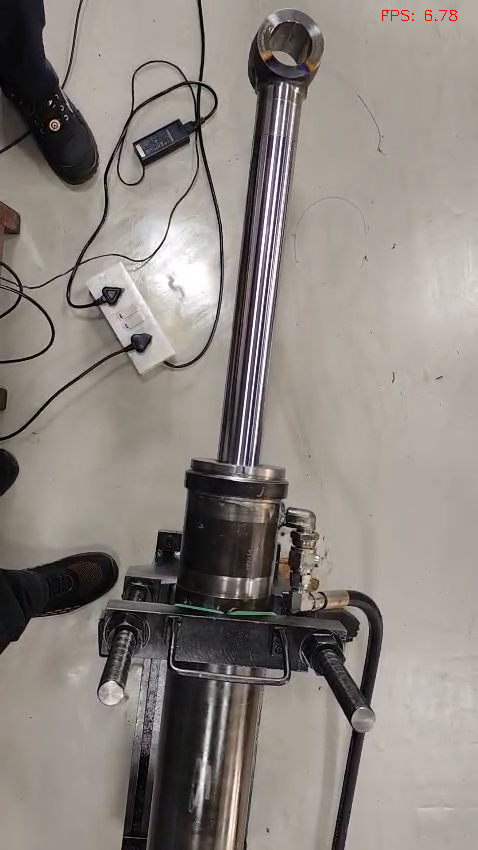

In [33]:
# Dictionary to store previous position and time for each track
track_prev = {}

while True:
    start = datetime.datetime.now()  # Record the start time

    ret, frame = video_cap.read()  # Read a frame from the video
    if not ret:
        break
    
    # Detect objects using YOLO
    detections = model(frame)[0]
    results = []
    for data in detections.boxes.data.tolist():
        confidence = data[4]
        if float(confidence) < CONFIDENCE_THRESHOLD:
            continue
        xmin, ymin, xmax, ymax = int(data[0]), int(data[1]), int(data[2]), int(data[3])
        class_id = int(data[5])
        results.append([[xmin, ymin, xmax - xmin, ymax - ymin], confidence, class_id])
        
    # Update tracks with DeepSort
    tracks = tracker.update_tracks(results, frame=frame)
    for track in tracks:
        if not track.is_confirmed():
            continue

        track_id = track.track_id
        ltrb = track.to_ltrb()
        xmin, ymin, xmax, ymax = int(ltrb[0]), int(ltrb[1]), int(ltrb[2]), int(ltrb[3])

        # Calculate current position (center of bounding box)
        current_pos = ((xmin + xmax) / 2, (ymin + ymax) / 2)
        current_time = start

        # Calculate speed if previous data exists
        if track_id in track_prev:
            prev_time, prev_pos = track_prev[track_id]
            delta_t = (current_time - prev_time).total_seconds()
            if delta_t > 0:
                delta_x = current_pos[0] - prev_pos[0]
                delta_y = current_pos[1] - prev_pos[1]
                distance = math.sqrt(delta_x**2 + delta_y**2)
                speed = distance / delta_t
            else:
                speed = 0
        else:
            speed = 0  # No speed for the first frame of a track

        # Update previous position and time
        track_prev[track_id] = (current_time, current_pos)

        # Draw bounding box
        cv2.rectangle(frame, (xmin, ymin), (xmax, ymax), GREEN, 2)
        # Draw text background rectangle (extended for ID and speed)
        cv2.rectangle(frame, (xmin, ymin - 40), (xmin + 100, ymin), GREEN, -1)
        # Draw track ID and speed
        cv2.putText(frame, f"ID: {track_id}", (xmin + 5, ymin - 25), cv2.FONT_HERSHEY_SIMPLEX, 0.5, WHITE, 2)
        cv2.putText(frame, f"Speed: {speed:.2f} px/s", (xmin + 5, ymin - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, WHITE, 2)
        
    # Calculate and display FPS
    end = datetime.datetime.now()
    print(f"Time to process 1 frame: {(end - start).total_seconds() * 1000:.0f} milliseconds")
    fps = f"FPS: {1 / (end - start).total_seconds():.2f}"
    cv2.putText(frame, fps, (380, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)

    # Convert and display the frame
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    img_pil = Image.fromarray(frame_rgb)
    clear_output(wait=True)
    display(img_pil)


In [ ]:
def show_image(img):
    if len(img.shape) == 3 and img.shape[2] == 3:
        # Color image (BGR to RGB)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_pil = Image.fromarray(img_rgb)
    elif len(img.shape) == 2 or (len(img.shape) == 3 and img.shape[2] == 1):
        # Grayscale image
        img_pil = Image.fromarray(img.squeeze(), mode='L')
    else:
        raise ValueError("Unsupported image shape: {}".format(img.shape))
    display(img_pil)


### create frames

In [ ]:
import os

output_dir = "data/frames"
os.makedirs(output_dir, exist_ok=True)

video_cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
frame_count = int(video_cap.get(cv2.CAP_PROP_FRAME_COUNT))

saved_frames = []
for i in range(frame_count):
    ret, frame = video_cap.read()
    if not ret:
        break
    frame_path = os.path.join(output_dir, f"frame_{i:04d}.jpg")
    cv2.imwrite(frame_path, frame)
    saved_frames.append(frame_path)

print(f"Saved {len(saved_frames)} frames to {output_dir}")

In [12]:
def show_image(img):
    if len(img.shape) == 3:  # 3 channels (BGR)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_pil = Image.fromarray(img_rgb)
    else:   # single channel (grayscale)
        img_pil = Image.fromarray(img)
    display(img_pil)

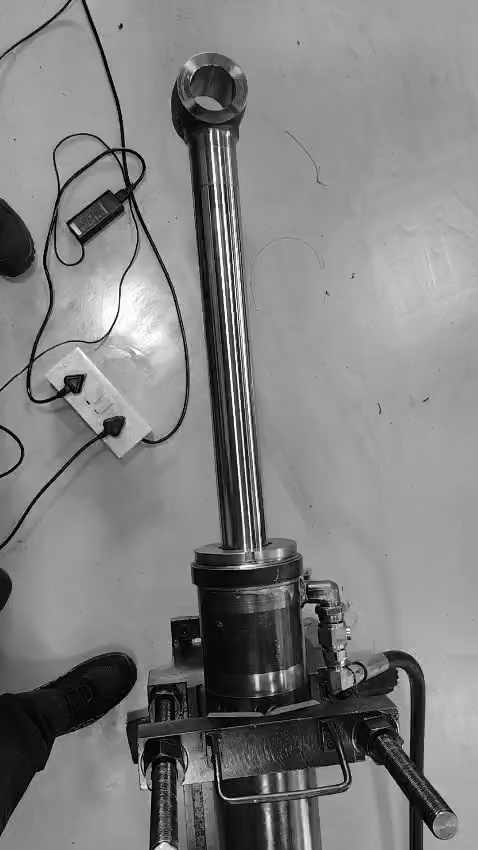

In [21]:
img = cv2.imread(r"E:\AW\Computer Vision\Wipro\data\frames\frame_0000.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
show_image(gray)

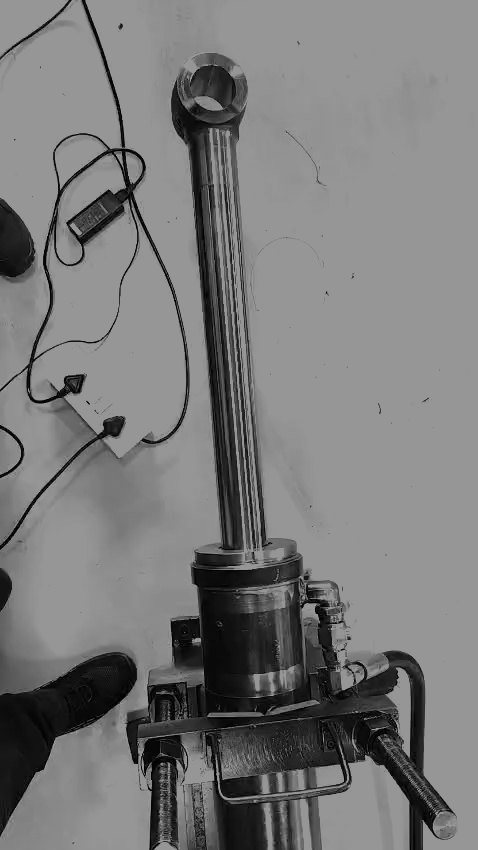

In [32]:
_, binary = cv2.threshold(gray, 150, 255, cv2.THRESH_TRUNC)
show_image(binary)

In [ ]:
from ultralytics import YOLO
import yaml

model = YOLO('yolov8n.pt')
yaml_path = r"E:\AW\Computer Vision\Wipro\data\Yolov8_train\custom_data.yaml"

results = model.train(
    data=yaml_path,
    epochs=100,
    imgsz=640,
    project='model_training/runs02/train', # Directory to save training runs
    name='model01' # Name for the specific training run
)

print("Training complete.")

In [38]:
import matplotlib.pyplot as plt

def detect_knob(img):
    if img is None:
        print(f"Error: Could not load image")
        exit()
    
    model_path = r"E:\AW\Computer Vision\Wipro\model_training\runs01\train\model014\weights\best.pt"
    model = YOLO(model_path)
    crops = []
    # You can specify device='cpu' explicitly to ensure it runs on CPU
    results = model(img, conf=0.5, iou=0.7, device='cpu') # conf: confidence threshold, iou: NMS IoU threshold
    for r in results:
        boxes = r.boxes # Bounding boxes
        for box in boxes:
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int) # Get bounding box coordinates
            confidence = box.conf[0].cpu().numpy() # Confidence score
            # class_id = box.cls[0].cpu().numpy().astype(int) # Class ID
            class_id = int(box.cls[0])            
            if model.names[class_id] == 'pump_knob':
                center_x = int((x1 + x2) / 2)
                center_y = int((y1 + y2) / 2)
                # Take the average of width and height for radius, or consider the smaller dimension
                radius = int(min(x2 - x1, y2 - y1) / 2)
                cv2.circle(img, (center_x, center_y), radius, (0, 0, 255), 1)
                crops.append(img[x1:x2, y1:y2])
                label = f'{model.names[class_id]}: {confidence:.2f}'
                cv2.putText(img, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Detected Bolt Fixation Areas')
    plt.axis('off')
    plt.show()
    return crops


0: 640x384 1 pump_knob, 75.3ms
Speed: 1.5ms preprocess, 75.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 384)


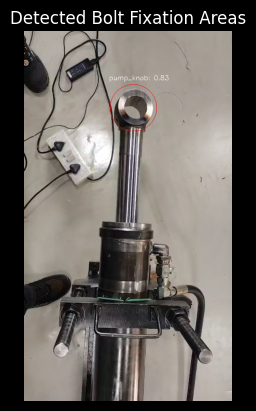

In [43]:
image_path = r"E:\AW\Computer Vision\Wipro\data\frames\frame_0613.jpg"
img = cv2.imread(image_path)
crops = detect_knob(img)    